<h3>Import Packages</h3>

In [1]:
import pandas as pd
import numpy as np
from langdetect import detect_langs
import string
from wordcloud import WordCloud, STOPWORDS
from textblob import TextBlob

import matplotlib.pyplot as plt
import seaborn as sns
import warnings

sns.set()
%matplotlib inline
%config InlineBackend.figure_formats = ['svg']
warnings.filterwarnings('ignore')

<h3>Load Dataset</h3>

In [2]:
data = pd.read_csv("data/amazon_review_vacuumer.csv", sep=",", encoding="utf-8")
data.head()

review_title  \
0  \n\n\n\n\n\n\n\n  \n  \n    Better than crossw...   
1  \n\n\n\n\n\n\n\n  \n  \n    Can't complain, to...   
2  \n\n\n\n\n\n\n\n  \n  \n    A wonderful device...   
3  \n\n\n\n\n\n\n\n  \n  \n    Bad experiences\n  \n   
4  \n\n\n\n\n\n\n\n  \n  \n    Stopped working af...   

                                         review_text         review_star  \
0  \n\n\n\n\n\n\n\n\n\n  \n  \n    \n  Literally ...  5.0 out of 5 stars   
1  \n\n\n\n\n\n\n\n\n\n  \n  \n    \n  Works amaz...  4.0 out of 5 stars   
2  \n\n\n\n\n\n\n\n\n\n  \n  \n    \n  This water...  5.0 out of 5 stars   
3  \n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n    \n  ...  1.0 out of 5 stars   
4  \n\n\n\n\n\n\n\n\n\n  \n  \n    \n  Like the o...  1.0 out of 5 stars   

   veri             revdate  nhelpful1  page_num  
0     1    February 8, 2021        NaN       127  
1     1    October 22, 2020        NaN       127  
2     1  September 10, 2021        NaN       127  
3     1       July 14, 2021        1.0       127  
4     1      March 14, 2021        1.0       127

In [3]:
data.dtypes

review_title     object
review_text      object
review_star      object
veri              int64
revdate          object
nhelpful1       float64
page_num          int64
dtype: object

<h3>Arrange Settings</h3>

In [4]:
# Change format
data["review_star"] = data["review_star"].str[0].astype("int")
data["revdate"] = pd.to_datetime(data["revdate"])

# Text preparation
# Remove "\n" & leading and trailing whitespace
data["review_text"] = data["review_text"].str.translate({ord('\n'): None}).str.strip()
data["review_title"] = data["review_title"].str.translate({ord('\n'): None}).str.strip()

**Time frame of reviews**

In [5]:
print("The reviews took place in a period between %s and %s." %(str(data["revdate"].min()).split(" ")[0], str(data["revdate"].max()).split(" ")[0]))

The reviews took place in a period between 2020-03-29 and 2022-03-20.


**Remove all non-English review texts and reviews without a text**

In [6]:
languages = []
# Detect the language of the foreign string
for review in data["review_text"]:
    try:
        languages.append(str(detect_langs(review)[0])[0:2])
    except:
        languages.append("Error")
data = data[np.array(languages) == "en"]

<h3>First insight into the data</h3>

<h5>Distribution of Stars</h5>

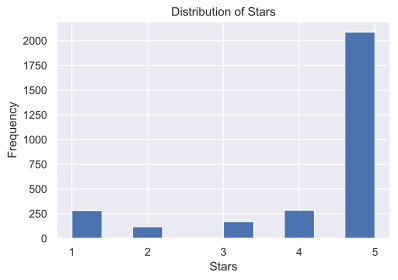

In [7]:
# Distribution of Stars
plot1 = data["review_star"].astype("str").sort_values()
plt.hist(plot1)
plt.xlabel("Stars")
plt.ylabel("Frequency")
plt.title(label="Distribution of Stars")
plt.show()

<h5>How does the rating evolve over time?</h5>

In [8]:
# Change date to Y-M
data["revdate_month"] = data["revdate"].dt.to_period("M")
data["revdate_month"] = data["revdate_month"].astype("str")

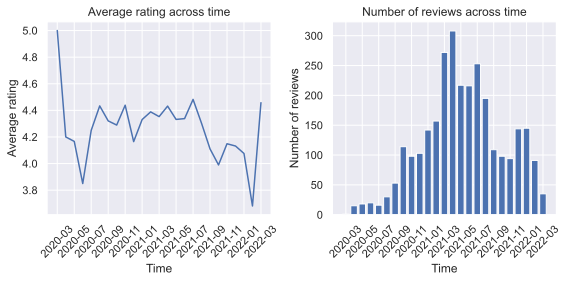

In [9]:
plt.rcParams["figure.figsize"] = (8,4)
fig,(ax1, ax2) = plt.subplots(1,2)

# Average rating across time
plot2 = data.groupby("revdate_month").mean().reset_index()
ax1.plot("revdate_month","review_star", data=plot2)
ax1.set_xticklabels(plot2["revdate_month"][::2], rotation=45)
ax1.set_xticks(np.arange(0, len(plot2["revdate_month"])+1, 2))
ax1.set_title("Average rating across time")
ax1.set_xlabel("Time")
ax1.set_ylabel("Average rating")

# Number of reviews across time
plot3 = data.groupby("revdate_month").count().reset_index()
ax2.bar("revdate_month","review_title", data=plot3)
ax2.set_xticklabels((plot3["revdate_month"][::2]), rotation=45)
ax2.set_xticks(np.arange(0, len(plot3["revdate_month"])+1, 2))
ax2.set_title("Number of reviews across time")
ax2.set_xlabel("Time")
ax2.set_ylabel("Number of reviews")

fig.tight_layout()
plt.show()

<h5>What fraction of reviews are perceived as helpful?</h5>

In [10]:
data["nhelpful1"] = data["nhelpful1"].replace(np.nan, 0)

print("Overall franction of helpful reviews %s"
%(round(data[data["nhelpful1"] > 0]["nhelpful1"].count() / data["nhelpful1"].count(),4)))


Overall franction of helpful reviews 0.2014


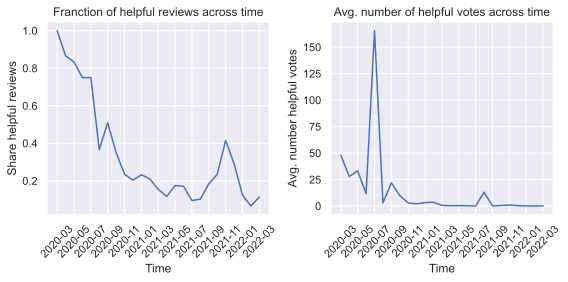

In [11]:
plt.rcParams["figure.figsize"] = (8,4)
fig,(ax1, ax2) = plt.subplots(1,2)

# Average rating across time
plot4 = (data[data["nhelpful1"] > 0].groupby("revdate_month").count()["nhelpful1"] / data.groupby("revdate_month").count()["nhelpful1"]).reset_index()
ax1.plot("revdate_month","nhelpful1", data=plot4)
ax1.set_xticklabels(plot4["revdate_month"][::2], rotation=45)
ax1.set_xticks(np.arange(0, len(plot2["revdate_month"])+1, 2))
ax1.set_title("Franction of helpful reviews across time")
ax1.set_xlabel("Time")
ax1.set_ylabel("Share helpful reviews")

# Number of reviews across time
plot5 = data.groupby("revdate_month").mean()["nhelpful1"].reset_index()
ax2.plot("revdate_month","nhelpful1", data=plot5)
ax2.set_xticklabels(plot5["revdate_month"][::2], rotation=45)
ax2.set_xticks(np.arange(0, len(plot5["revdate_month"])+1, 2))
ax2.set_title("Avg. number of helpful votes across time")
ax2.set_xlabel("Time")
ax2.set_ylabel("Avg. number helpful votes")

fig.tight_layout()
plt.show()

In [12]:
print("Number of reviews: %s\nNumber of verified reviews: %s" %(data.veri.count(), data.veri.sum()))
# Make a subset and keep verified purchases only
data_v = data[data.veri == 1]

Number of reviews: 2944
Number of verified reviews: 2943


<h3>First insights into review contents</h3>

<h5>How is the correlation between title and text length?</h5>

In [13]:
# Text
# remove all sort of punctuation
data_v["text"] = data_v.review_text.str.translate(str.maketrans('', '', string.punctuation)).str.lower()
# count the number of words
data_v["text_length"] = data_v["text"].str.split(" ").str.len()

# Title
# remove all sort of punctuation
data_v["title"] = data_v.review_title.str.translate(str.maketrans('', '', string.punctuation)).str.lower()
# count the number of words
data_v["title_length"] = data_v["title"].str.split(" ").str.len()

count    2943.000000
mean       74.368332
std        81.640764
min         1.000000
25%        24.000000
50%        49.000000
75%        97.000000
max      1024.000000
Name: text_length, dtype: float64 

 count    2943.000000
mean        4.227999
std         2.808650
min         1.000000
25%         2.000000
50%         4.000000
75%         6.000000
max        20.000000
Name: title_length, dtype: float64


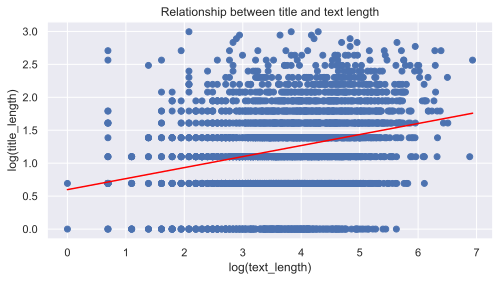

In [14]:
# Get some stats
print(data_v["text_length"].describe(),"\n\n", data_v["title_length"].describe())
# Relationship between title and text length
x, y = np.log(data_v["text_length"]), np.log(data_v["title_length"])
plt.scatter(x, y)
k,d = np.polyfit(x, y, 1) # Linear Regression
plt.plot(x, k*x+d, color="red")
plt.xlabel("log(text_length)")
plt.ylabel("log(title_length)")
plt.title(label="Relationship between title and text length")
plt.show()

<h3>Generate Wordclouds</h3>

<h5>Wordcloud title and text for all reviews</h5>

In [15]:
allWords_text = " ".join([text for text in data_v["text"]])
allWords_title = " ".join([title for title in data_v["title"]])
stopwords = ["vacuum", "machine", "tineco"] + list(STOPWORDS)

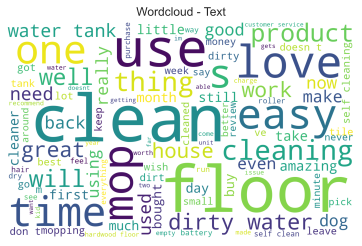

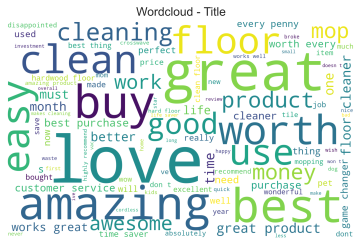

In [16]:
# All Reviews - text
wordcloud1 = WordCloud(stopwords=stopwords,width=1600, height=1000,random_state=10, max_font_size=300,max_words=100, background_color="white").generate(allWords_text)
plt.figure(dpi=500)
plt.imshow(wordcloud1, interpolation="bilinear")
plt.axis("off")
plt.title("Wordcloud - Text")
plt.show()

# All Reviews - title
wordcloud2 = WordCloud(stopwords=stopwords,width=1600, height=1000,random_state=10, max_font_size=300,max_words=100, background_color="white").generate(allWords_title)
plt.figure(dpi=500)
plt.imshow(wordcloud2, interpolation="bilinear")
plt.axis("off")
plt.title("Wordcloud - Title")
plt.show()

<h5>Wordcloud title and text for 5 star reviews</h5>

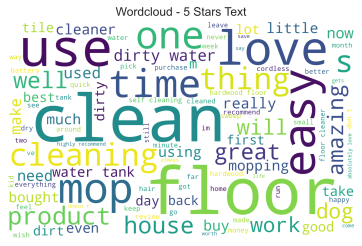

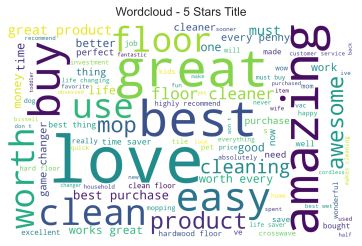

In [17]:
stars5_Words_text = " ".join([text for text in data_v[data_v["review_star"] == 5]["text"]])
stars5_Words_title = " ".join([title for title in data_v[data_v["review_star"] == 5]["title"]])

# 5 Star Reviews - text
wordcloud3 = WordCloud(stopwords=stopwords,width=1600, height=1000,random_state=10, max_font_size=300,max_words=100, background_color="white").generate(stars5_Words_text)
plt.figure(dpi=500)
plt.imshow(wordcloud3, interpolation="bilinear")
plt.axis("off")
plt.title("Wordcloud - 5 Stars Text")
plt.show()

# 5 Star Reviews - title
wordcloud4 = WordCloud(stopwords=stopwords,width=1600, height=1000,random_state=10, max_font_size=300,max_words=100, background_color="white").generate(stars5_Words_title)
plt.figure(dpi=500)
plt.imshow(wordcloud4, interpolation="bilinear")
plt.axis("off")
plt.title("Wordcloud - 5 Stars Title")
plt.show()

<h5>Wordcloud title and text for 1 star reviews</h5>

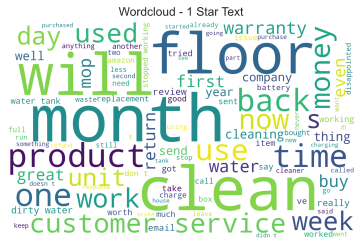

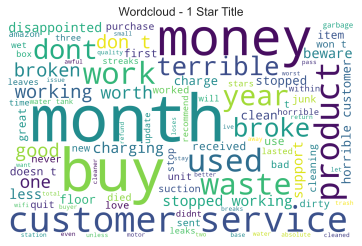

In [18]:
stars1_Words_text = " ".join([text for text in data_v[data_v["review_star"] == 1]["text"]])
stars1_Words_title = " ".join([title for title in data_v[data_v["review_star"] == 1]["title"]])

# 5 Star Reviews - text
wordcloud5 = WordCloud(stopwords=stopwords,width=1600, height=1000,random_state=10, max_font_size=300,max_words=100, background_color="white").generate(stars1_Words_text)
plt.figure(dpi=500)
plt.imshow(wordcloud5, interpolation="bilinear")
plt.axis("off")
plt.title("Wordcloud - 1 Star Text")
plt.show()

# 5 Star Reviews - title
wordcloud6 = WordCloud(stopwords=stopwords,width=1600, height=1000,random_state=10, max_font_size=300,max_words=100, background_color="white").generate(stars1_Words_title)
plt.figure(dpi=500)
plt.imshow(wordcloud6, interpolation="bilinear")
plt.axis("off")
plt.title("Wordcloud - 1 Star Title")
plt.show()

<h3>Get subjectivity and polarity from review text and title</h3>

In [19]:
# Get subjectivity
def getSubjectivity(text):
    return TextBlob(text).sentiment.subjectivity

# Get polarity
def getPolarity(text):
    return TextBlob(text).sentiment.polarity

# Create subjectivity and polarity column
data_v["Subjectivity_text"] = data_v["text"].apply(getSubjectivity)
data_v["Polarity_text"] = data_v["text"].apply(getPolarity)
data_v["Subjectivity_title"] = data_v["title"].apply(getSubjectivity)
data_v["Polarity_title"] = data_v["title"].apply(getPolarity)

# Get negative, neutral and positive analysis based on polarity
data_v["Analysis"] = np.where(data_v["Polarity_text"] > 0, "positive", np.where(data_v["Polarity_text"] < 0, "negative", "neutral"))

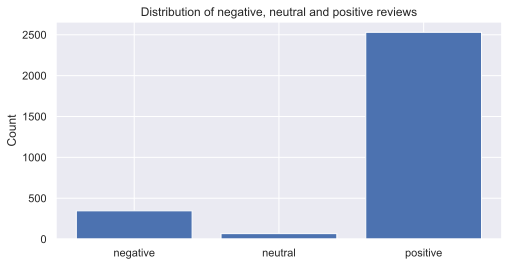

In [20]:
# Distribution of negative, neutral and positive text reviews
plot6 = data_v.groupby("Analysis").count()["text"].reset_index()
plt.ylabel("Count")
plt.title(label="Distribution of negative, neutral and positive reviews")
plt.bar("Analysis", "text", data=plot6)
plt.show()

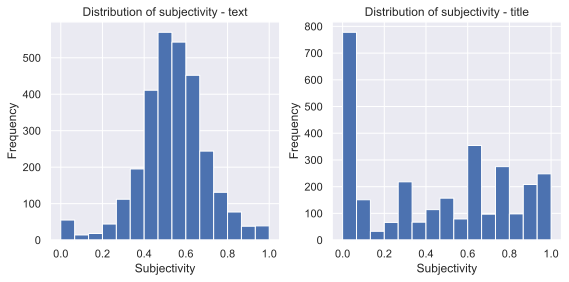

In [21]:
# Distribution of subjectivity in text and title
plt.rcParams["figure.figsize"] = (8,4)
fig,(ax1, ax2) = plt.subplots(1,2)

# Average rating across time
ax1.hist(data_v["Subjectivity_text"], bins=15)
ax1.set_title("Distribution of subjectivity - text")
ax1.set_xlabel("Subjectivity")
ax1.set_ylabel("Frequency")

# Number of reviews across time
ax2.hist(data_v["Subjectivity_title"], bins=15)
ax2.set_title("Distribution of subjectivity - title")
ax2.set_xlabel("Subjectivity")
ax2.set_ylabel("Frequency")

fig.tight_layout()
plt.show()